In [8]:
import os, sys
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.data_io import load_h5_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels

In [21]:
from include.decoder_conv import init_convdecoder
from include.fit import fit, forwardm
from utils.transform import ifft_2d, fft_2d
from include.mri_helpers import apply_mask
import copy

torch.cuda.set_device(3)

# TODO
- build empirical loss adjustment per akshay rec
    - make sure we are penalizing e1, e2 similarly
    - what is the loss for e1, e2 separately? print these in ipynb
        - if similar, then network is expressing each equally
        - if not, want to re-balance these w empirical adjustment
    - figure out what this means in terms of t2 maps...

In [10]:
file_id = '005'
ksp = load_h5_qdess(file_id)

# load, concat both echo slices
idx_kx = ksp.shape[0] // 2 # want central slice in kx (axial) b/c we undersample in (ky,kz)
ksp_echo1 = ksp[:,:,:,0,:].permute(3,0,1,2)[:, idx_kx, :, :]
ksp_echo2 = ksp[:,:,:,1,:].permute(3,0,1,2)[:, idx_kx, :, :]
ksp_orig = torch.cat((ksp_echo1, ksp_echo2), 0)

In [11]:
print(ksp_orig.shape)

torch.Size([16, 512, 160])


In [14]:
net, net_input, ksp_orig_ = init_convdecoder(ksp_orig)

ksp_masked, mask = apply_mask(ksp_orig_, accel=4)
im_masked = ifft_2d(ksp_masked)

In [38]:
net, l_e1, l_e2 = fit(ksp_masked=ksp_masked, img_masked=im_masked,
                       net=net, net_input=net_input, mask=mask, 
                       num_iter=1000)

### findings

- loss for e1 is higher initially
- loss for e2 doesn't really decrease until e1 is same

In [44]:
for idx in np.arange(len(l_e1)):
    if idx % 50 == 0:
        print(l_e1[idx], l_e2[idx])

0.03476027399301529 0.024845484644174576
0.06083500385284424 0.030306167900562286
0.04306095838546753 0.027166375890374184
0.0417679138481617 0.026195574551820755
0.034071121364831924 0.024922484531998634
0.03151407465338707 0.024212108924984932
0.030419494956731796 0.023715540766716003
0.029395338147878647 0.023308541625738144
0.030759822577238083 0.023028738796710968
0.026678243651986122 0.022351644933223724
0.02651272341609001 0.022076310589909554
0.024549011141061783 0.02159462869167328
0.024873077869415283 0.021346863359212875
0.026411673054099083 0.021431464701890945
0.022355729714035988 0.02060544304549694
0.023955088108778 0.020804155617952347
0.0226440392434597 0.02043996751308441
0.023784033954143524 0.020198339596390724
0.02053171955049038 0.019669849425554276
0.02014797553420067 0.0193400289863348


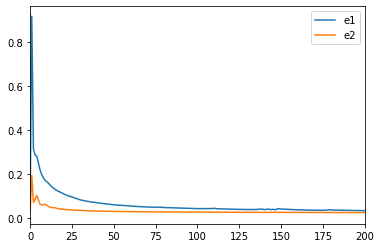

In [42]:
plt.plot(l_e1, label='e1')
plt.plot(l_e2, label='e2')
plt.xlim([0, 200])
plt.legend()
plt.show()

In [37]:
def fit(ksp_masked, img_masked, net, net_input, mask, mask2=None,
        num_iter=10000, lr=0.01, img_ls=None, dtype=torch.cuda.FloatTensor,
        LAMBDA_TV=1e-8):

    # initialize variables
    if img_ls is not None or net_input is None:
        raise NotImplementedError('incorporate original code here')
    net_input = net_input.type(dtype)
    best_net = copy.deepcopy(net)
    best_mse = 10000.0
    #mse_wrt_ksp, mse_wrt_img = np.zeros(num_iter), np.zeros(num_iter)

    p = [x for x in net.parameters()]
    optimizer = torch.optim.Adam(p, lr=lr,weight_decay=0)
    mse = torch.nn.MSELoss()

    # convert complex [nc,x,y] --> real [2*nc,x,y] to match w net output
    ksp_masked = reshape_complex_vals_to_adj_channels(ksp_masked).cuda()
    img_masked = reshape_complex_vals_to_adj_channels(img_masked)[None,:].cuda()
    mask = mask.cuda()
    if mask2 != None:
        mask2 = mask2.cuda()
        
    l_e1, l_e2 = np.empty(num_iter), np.empty(num_iter)

    for i in range(num_iter):
        def closure(): # execute this for each iteration (gradient step)

            optimizer.zero_grad()

            out = net(net_input) # out is in img space

            out_img_masked = forwardm(out, mask, mask2) # img-->ksp, mask, convert to img

            if mask2==None:# and i % 100 == 0:
                loss_e1 = mse(out_img_masked[0, :8], img_masked[0, :8]) + \
                          mse(out_img_masked[0, 16:24], img_masked[0, 16:24])
                loss_e2 = mse(out_img_masked[0, 8:16], img_masked[0, 8:16]) + \
                          mse(out_img_masked[0, 24:32], img_masked[0, 24:32])
                loss_e1, loss_e2 = loss_e1.data.cpu().numpy(), \
                                   loss_e2.data.cpu().numpy()
                l_e1[i], l_e2[i] = loss_e1, loss_e2
#                 print(loss_e1, loss_e2)

            loss_img = mse(out_img_masked, img_masked)

            loss_tv = (torch.sum(torch.abs(out_img_masked[:,:,:,:-1] - \
                                           out_img_masked[:,:,:,1:])) \
                     + torch.sum(torch.abs(out_img_masked[:,:,:-1,:] - \
                                           out_img_masked[:,:,1:,:])))
            loss_total = loss_img + LAMBDA_TV * loss_tv

            loss_total.backward(retain_graph=False)

            # mse_wrt_ksp[i] = loss_ksp.data.cpu().numpy() # store loss over each iteration

            return loss_total

        loss = optimizer.step(closure)

        # at each iteration, check if loss improves by 1%. if so, a new best net
        loss_val = loss.data
        if best_mse > 1.005*loss_val:
            best_mse = loss_val
            best_net = copy.deepcopy(net)

    return best_net, l_e1, l_e2#, mse_wrt_ksp, mse_wrt_img